In [149]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import cross_val_score
import nltk
nltk.download('punkt')
%matplotlib inline  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
smsdata = pd.read_csv('SMSSpamCollection', encoding = 'latin_1', sep='\t', header = None)
smsdata.columns = ['label', 'message']
smsdata.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
# spams = {'spam': 1, 'ham': 0}
# df['spam'] = df['label'].map(spams).astype(int)
# df.drop(['label'], axis = 1, inplace = True)
smsdata.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


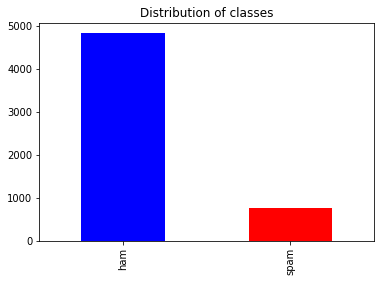

In [0]:
num_class=pd.value_counts(smsdata["label"], sort= True)
num_class.plot(kind= 'bar', color= ["blue", "red"])
plt.title('Distribution of classes')
plt.show()

Preprocessing instruments:
1. Lowercase words and sentences to have unified formats
2. Use 'bag of words' technique

In [0]:
smsdata['message'] = smsdata['message'].str.lower()
smsdata['message'] = smsdata['message'].apply(lambda i: i.translate(str.maketrans('', '', string.punctuation)))
smsdata['message'] = smsdata['message'].apply(nltk.word_tokenize)
stemmer = PorterStemmer()
smsdata['message'] = smsdata['message'].apply((lambda i: [stemmer.stem(words) for words in i]))

In [0]:
smsdata.head()

,label,message
0,ham,"[go, until, jurong, point, crazi, avail, onli,..."
1,ham,"[ok, lar, joke, wif, u, oni]"
2,spam,"[free, entri, in, 2, a, wkli, comp, to, win, f..."
3,ham,"[u, dun, say, so, earli, hor, u, c, alreadi, t..."
4,ham,"[nah, i, dont, think, he, goe, to, usf, he, li..."


In [0]:
def bag_of_words(data): #bag of words function
    
    list_freqdist = []
    for x in data:
        list_freqdist.append(dict(Counter(x)))
    
    all_words = list(set([y for x in data for y in x]))
    
    for doc in list_freqdist:
        for word in all_words:
            if word not in list(doc.keys()):
                doc[word] = 0
    
    vocab = pd.DataFrame(list_freqdist)
    return vocab

In [0]:
vocab = bag_of_words(smsdata['message'])

In [0]:
vocab['label'] = smsdata['label']
vocab # actual bag of words

,go,until,jurong,point,crazi,avail,onli,in,bugi,n,great,world,la,e,buffet,cine,there,got,amor,wat,4tctxt,ahwhat,buzi,sorryin,09064017305,visitne,twenti,dont,0125698789,puttin,pan,3xâ£150pw,255,ext,improv,prasanth,woken,swear,attent,semi,...,10,glo,missunderstd,3230,behav,night,simul,machiani,el,mental,wordstart,monl8rsx,ratetc,ovarian,ptbo,um,frontiervil,deer,â£5000,drama,sorryi,readyal,thnk,feet,fab,realiti,gail,checkup,82324,misundrstud,fave,lil,day2find,enough,wrote,lambda,lm,nowcan,paus,label
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ham
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ham
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,spam
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ham
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ham
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,spam
5568,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ham
5569,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ham
5570,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ham


In [0]:
number_of_words = len(vocab.columns) - 1 #total number of words in vocabulary
number_of_words

8288

In [0]:
labels = vocab.groupby(by='label', axis=0) # to see how many messages each class has
words_in_each_class = labels.sum() #how often each word is met in a class
words_in_each_class

,go,until,jurong,point,crazi,avail,onli,in,bugi,n,great,world,la,e,buffet,cine,there,got,amor,wat,4tctxt,ahwhat,buzi,sorryin,09064017305,visitne,twenti,dont,0125698789,puttin,pan,3xâ£150pw,255,ext,improv,prasanth,woken,swear,attent,semi,...,nowonion,10,glo,missunderstd,3230,behav,night,simul,machiani,el,mental,wordstart,monl8rsx,ratetc,ovarian,ptbo,um,frontiervil,deer,â£5000,drama,sorryi,readyal,thnk,feet,fab,realiti,gail,checkup,82324,misundrstud,fave,lil,day2find,enough,wrote,lambda,lm,nowcan,paus
label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ham,417,22,1,17,10,13,132,815,7,137,101,34,7,78,2,7,211,244,1,108,0,1,3,2,0,1,2,265,1,2,2,0,1,1,2,1,2,1,1,1,...,1,10,1,1,1,3,112,1,1,1,2,0,1,0,1,3,1,1,1,0,1,1,1,7,4,2,1,1,1,0,1,3,2,0,27,1,1,1,1,0
spam,35,5,0,16,5,3,79,73,0,9,11,2,0,6,0,0,15,7,0,1,2,0,0,0,1,0,0,22,0,0,0,1,0,0,2,0,0,0,0,0,...,0,6,0,0,0,0,7,0,0,0,0,2,0,2,0,0,0,0,0,20,0,0,0,0,0,0,2,0,0,1,0,0,0,2,2,1,0,0,0,1


In [0]:
ham = (vocab['label']== 'ham').sum()
spam = (vocab['label']== 'spam').sum()

In [0]:
#find probability that sentence is ham or spam
p_ham = ham / (ham + spam)
p_spam = spam / (ham + spam)
prob_class = {'ham': p_ham,
             'spam': p_spam}
class0 = round(prob_class['ham'], 3)
class1 = round(prob_class['spam'], 3)
class0, class1

(0.866, 0.134)

In [0]:
words_num = words_in_each_class.sum(axis = 1) #overall number of words in 0 and 1 classes
words_in_spam = words_in_each_class.sum(axis = 1)[1]
words_in_ham = words_in_each_class.sum(axis = 1)[0]
words_in_spam, words_in_ham

(17649, 68143)

In [0]:
alpha = 1 #used for Laplacian smoothing and dealing with zeros

In [0]:
def p_w_spam(word): #calculate probability of the word in spam
    if word in vocab.columns:
        return (vocab.loc[vocab['label'] == 'spam', word].sum() + alpha) / (words_in_spam + alpha*number_of_words)
    else:
        return 0
      
def p_w_ham(word): #calculate probability of the word in ham
    if word in vocab.columns:
        return (vocab.loc[vocab['label'] == 'ham', word].sum() + alpha) / (words_in_ham + alpha*number_of_words)
    else:
        return 0

In [0]:
def classify(message):  #classifier function
    p_spam_given_message = class1
    p_ham_given_message = class0
    for word in message:
        p_spam_given_message *= p_w_spam(word)
        p_ham_given_message *= p_w_ham(word)
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'ham'

In [0]:
classify('bugi')

'ham'

In [0]:
from sklearn.model_selection import KFold #kFold validation split on 3 sets
kf = KFold(n_splits = 3, shuffle = True, random_state = 123)
result = list(kf.split(df))

In [0]:
result[0]

(array([   0,    1,    2, ..., 5566, 5568, 5569]),
 array([   4,   10,   11, ..., 5567, 5570, 5571]))

In [0]:
train1 = df.iloc[result[0][0]]
test1 =  df.iloc[result[0][1]]

train2 = df.iloc[result[1][0]]
test2 =  df.iloc[result[1][1]]

train3 = df.iloc[result[2][0]]
test3 =  df.iloc[result[2][1]]

In [0]:
train1['predicted'] = train1['message'].apply(classify)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
test1['predicted'] = test1['message'].apply(classify)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
train2['predicted'] = train2['message'].apply(classify)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
test2['predicted'] = test2['message'].apply(classify)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
train3['predicted'] = train3['message'].apply(classify)
test3['predicted'] = test3['message'].apply(classify)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
def correct(dataset):
    correct = round(((dataset['predicted'] == dataset['label']).sum() / dataset.shape[0] * 100), 3)
    return correct

In [0]:
print('Scores for 1st fold are: {} % for train sample, {} % for test sample'.format(correct(train1), correct(test1)))
print('Scores for 2nd fold are: {} % for train sample, {} % for test sample'.format(correct(train2), correct(test2)))
print('Scores for 3rd fold are: {} % for train sample, {} % for test sample'.format(correct(train3), correct(test3)))


Scores for 1st fold are: 99.058 % for train sample, 98.816 % for test sample
Scores for 2nd fold are: 99.004 % for train sample, 98.923 % for test sample
Scores for 3rd fold are: 98.869 % for train sample, 99.192 % for test sample


# The scikit Multinomial Naive Bayes calculation

In [150]:
smsdata2 = pd.read_csv('SMSSpamCollection', encoding = 'latin_1', sep='\t', header = None)
smsdata2.columns = ['label', 'message']
smsdata2.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
x = smsdata2['message']
y = smsdata2['label']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 123)

In [0]:
vectorizer= CV()
training_data = vectorizer.fit_transform(X_train.values)
test_data = vectorizer.transform(X_test)

In [154]:
classifier = MultinomialNB()
# actual = y_train.values
classifier.fit(training_data, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
y_train

385     spam
4003     ham
1283     ham
2327     ham
1103     ham
        ... 
5218     ham
4060    spam
1346     ham
3454     ham
3582     ham
Name: label, Length: 4457, dtype: object

In [0]:
predictions = classifier.predict(test_data)

In [156]:
print('Accuracy score: {}'.format(accuracy_score(y_test, predictions)))

Accuracy score: 0.9865470852017937


# Accuracy received in NB by scratch is 99.058 at its highest.
# Scikit NB accuracy is 98.654. 

# It probably would be better to compare F1 one scores, however, at accuracy a model from scratch performs better on test data.

https://github.com/Midvel/medium_jupyter_notes/blob/master/naive_bayes_filter/bayes-classificator.ipynb

https://github.com/q-viper/ML-from-Basics/blob/master/NLP%20Bayesian%20Scratch.ipynb

https://www.coursera.org/learn/python-text-mining/lecture/zV9nP/naive-bayes-classifiers

https://youtu.be/BqUmKsfSWho